In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct
import math

Variable initialization

In [2]:
N = 32 # signal dimension
M = 32 # number of atoms in the span (for basis M = N)

C = np.zeros((N, M)) # matrix containing the standard basis (a kronecker delta in each column)
D = np.zeros((N, M)) # matrix containing the DCT basis (a DCT function in each column)


Generate the 1D-DCT basis

Text(0.5, 1.0, 'DCT basis')

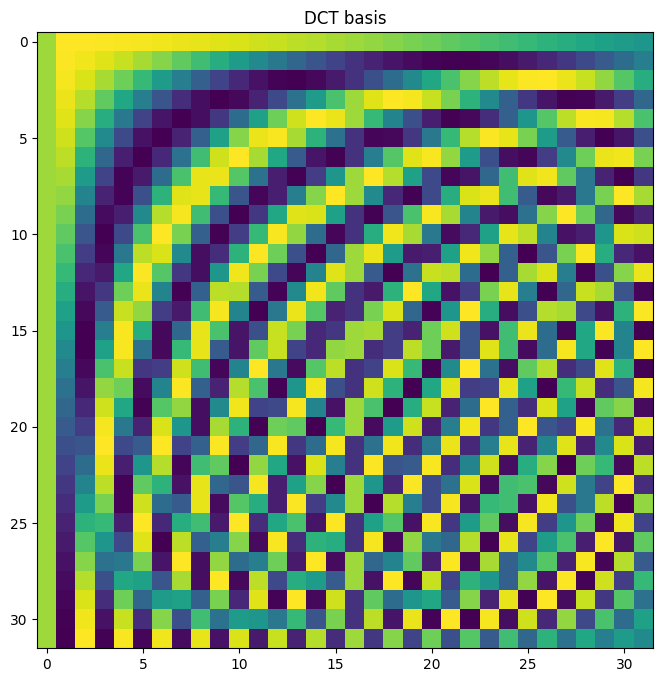

In [3]:
for i in range(M):
    a = np.zeros(N)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    D[:, i] = temp/norm

plt.figure(figsize=(8,8))
plt.imshow(D)
plt.title('DCT basis')

In [4]:
is_D_orth = True
for i in range(M):
    for j in range(N):
        dot_product = np.dot(D[:, i], D[:, j])
        if i != j:
            is_D_orth = np.isclose(dot_product, 0)
        else:
            is_D_orth = np.isclose(dot_product, 1)

        if(is_D_orth == False):
            break

print(f'DCT dictionary is orthogonal: {is_D_orth}')

DCT dictionary is orthogonal: True


# Sparsity w.r.t orthonormal dictionary D

In this section you will perform denoising of a signal that is *sparse* w.r.t. the orthornormal dictionary $D\in\mathbb{R}^{N\times N}$, i.e., the 1D-DCT dictionary.

At first, generate a vector $x_{orig}\in\mathbb{R}^N$ that is $L$-sparse, i.e. $\|x_{orig}\|_0 = L$. Use this coefficient vector $x_{orig}$, generate a noise-free signal $y\in\mathbb{R}^N$ as $y=Dx_{orig}$, and add some Gaussian noise to obtain $s = y + \eta$.

Perform the DCT denoising on the noisy signal $s$ to recover $\hat y$. Use the Hard Thresholding operator that keeps only the largest $L$ coefficients and evaluate the denoising performance


Set the sparsity level $L$

In [5]:
L = 3

Randomly define the coefficients of a sparse representation $x$ (make sure the nonzero coefficients are sufficiently large)

In [6]:
x_orig = np.zeros(M)
positions = np.random.choice(M, L, replace=False)
x_orig[positions] = np.random.rand(L)
x_orig

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33754867, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.78812757, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.77694695,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [7]:
#y=s0
y = np.dot(D,x_orig) # noise free
print(y.shape)

sigma = 10/255
sigma_noise = sigma * (np.random.normal(size=y.shape))

# s = s0 + eta
s = y + sigma_noise
print(s.shape)

(32,)
(32,)


Plot the sparse signal

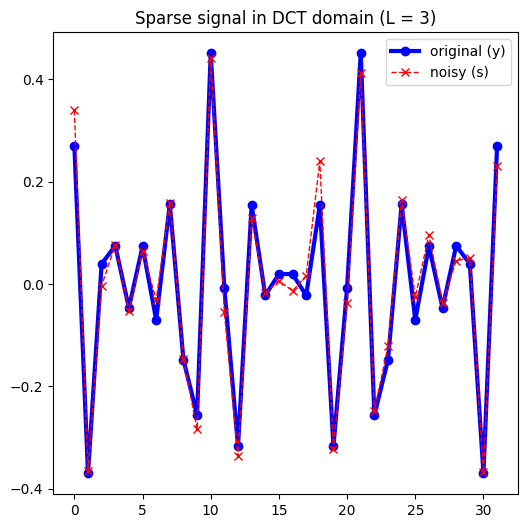

In [8]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6,6))
plt.plot(y, 'b-o', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original (y)', 'noisy (s)'])


### Implement the DCT denoising

This is expected to be very effective on $s$!

**Analysis**: compute the coefficients w.r.t. $D$

In [9]:
x = np.dot(D.T,s)
print(x)

[ 7.86229515e-04 -7.33329699e-03  1.57408791e-02  5.72174793e-02
 -6.04124801e-03  2.61010906e-03 -4.10336480e-02  5.78683320e-02
  4.42267215e-02 -5.97535691e-03  6.19825277e-02  4.63850989e-02
  3.08829707e-01  2.57296675e-02  4.55596972e-02  6.78752283e-03
 -3.67844985e-02  6.81355314e-02  8.06560808e-01  1.28998773e-02
  3.66589660e-03  2.42620237e-02  2.14636133e-03 -2.32139389e-02
  7.63280063e-01  1.06049714e-02 -1.86018824e-02 -2.80397084e-02
  7.93683673e-03 -1.55785057e-02  2.66634288e-02  2.08471847e-02]


**Hard Thresholding**: keep only the $L$ largest coefficients (absolute value)

In [10]:
x_copy = np.abs(x) # [3,1,2,-2,-5]
x_copy.sort() # [1,2,2,3,5]
gamma = x_copy[::-1][L-1] # [5,3,2,2,1] -> [2] if L = 3
x_hat = np.where(np.abs(x) < gamma, 0, x)


**Synthesis**: invert the transform

In [11]:
s_hat = np.dot(D,x_hat)

Plot the results:
- are the denoising performance good?
- are the original coefficients $x_{orig}$ recovered by $\hat x$?

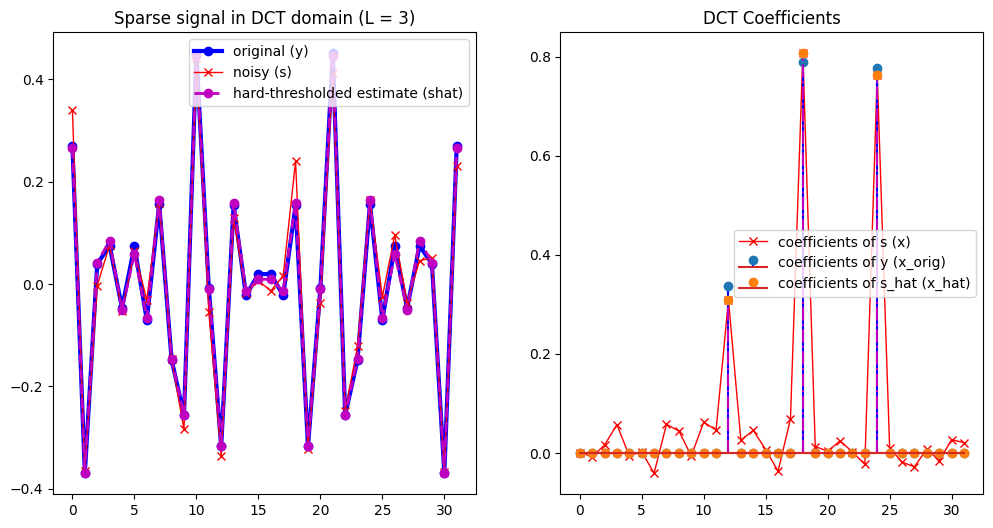

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])


# Sparsity w.r.t redoundant dictionary

In this section you will perform the same denoising as in the previous section with the only difference that the signal $s = y + \eta$ that you will generate is sparse w.r.t. a redoundant dictionary $A=[C, D] \in\mathbb{R}^{M \times N}$, where $C\in\mathbb{M\times M}$ is the matrix representity the canonical basis, and $D\in\mathbb{M\times M}$ is the usual 1D-DCT matrix. Therefore $A$ is a rectangular matrix, since $M < N$.

To generate signals that are sparse w.r.t. $A=[C, D]$, at first generate a signal $y$ that is $L-1$ sparse w.r.t. $D$ as you have done in the previous section. Then, add a spike to $y$ that is sparse w.r.t. $A$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise.

Generate the standard orthonormal basis

Text(0.5, 1.0, 'Canonical basis dimension n = 32')

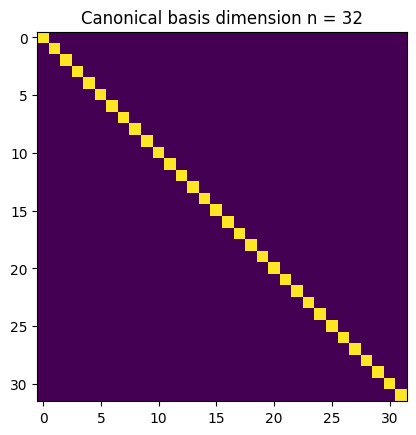

In [13]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a
# C = np.eye(M)

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}')

In [14]:
A = np.concatenate((C, D), axis=1)
A.shape

(32, 64)



Generate a signal that is sparse w.r.t. D

In [31]:
#to ask: aren't we supposed to use A?

In [32]:
# x_orig = np.random.rand(M)
x_orig = np.zeros(M)
positions = np.random.choice(M, L, replace=False)
x_orig[positions] = np.random.rand(L)

In [33]:
y = np.dot(D,x_orig) # noise free
print(y)
np.abs(max(y))

[ 0.12326734 -0.21555928  0.05059081  0.13909751 -0.10853681 -0.0745069
  0.14360706 -0.0100657  -0.12924548  0.0873179   0.05008315 -0.06661454
 -0.0566844   0.11219675  0.01974891 -0.17454102  0.12502212  0.08479245
 -0.17883798  0.02619081  0.16713843 -0.13128573 -0.09761433  0.22188883
 -0.08257764 -0.13331063  0.15570947  0.00801293 -0.10860392  0.01605042
  0.11101793 -0.07374844]


0.22188883163014056

Randomly place a spike in the first 20 samples of $y$


In [34]:
# choose spike location
spikeLocation = np.random.choice(20)
# modify the signal intensity at spikeLocation
# update y
lambda_spike = np.random.uniform(3,4) + (2*np.abs(max(y))/y[spikeLocation]) # para que al menos sea el doble de la señal mas intensa
y[spikeLocation] = lambda_spike * y[spikeLocation]
print(y[spikeLocation]) # verificar que sea mas alto que el max
print(spikeLocation)

-0.18272550008963823
15


Add noise to the signal

In [35]:
sigma = 2/255
sigma_noise = sigma * (np.random.normal(size=y.shape))

# s = s0 + eta
s = y + sigma_noise

Perform hard thresholding by keeping the largest $L$ coefficients w.r.t. $D$ (not $A$!)

In [36]:
# analysis: compute the coefficients w.r.t. D
x = np.dot(D.T,s)

# keep only the L largest coefficients (absolute value)
x_copy = np.abs(x) # [3,1,2,-2,-5]
x_copy.sort() # [1,2,2,3,5]
gamma = x_copy[::-1][L-1] # [5,3,2,2,1] -> [2] if L = 3
x_hat = np.where(np.abs(x) < gamma, 0, x)

# invert the transformation
s_hat = np.dot(D,s)

Plot the results and compare them to the one obtained in the previous section.

Is the signal $s$ denoised properly?

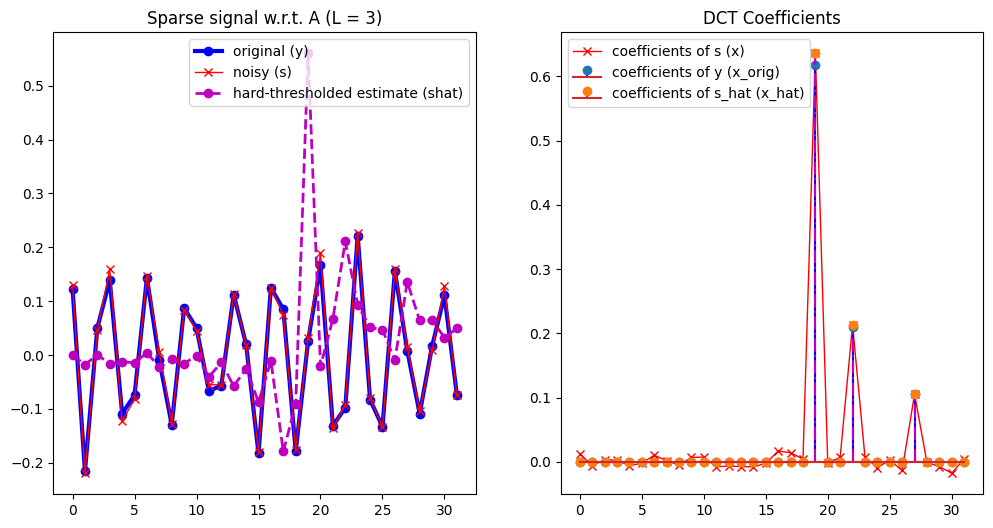

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])

## Tichonov Regularization


Compute the representation w.r.t. $A = [C, D]$ using Tichonov's regularization (try differente value for $\lambda$)

In [49]:
lmbda = 0.5 #1
den = np.linalg.inv(np.dot(A.T,A) + (lmbda*np.eye(64)))
x_hat_tic = np.dot(np.dot(A.T, y), den)
s_hat_tic = np.dot(A, x_hat_tic)


Show the results

Text(0.5, 1.0, 'Coefficients w.r.t. A')

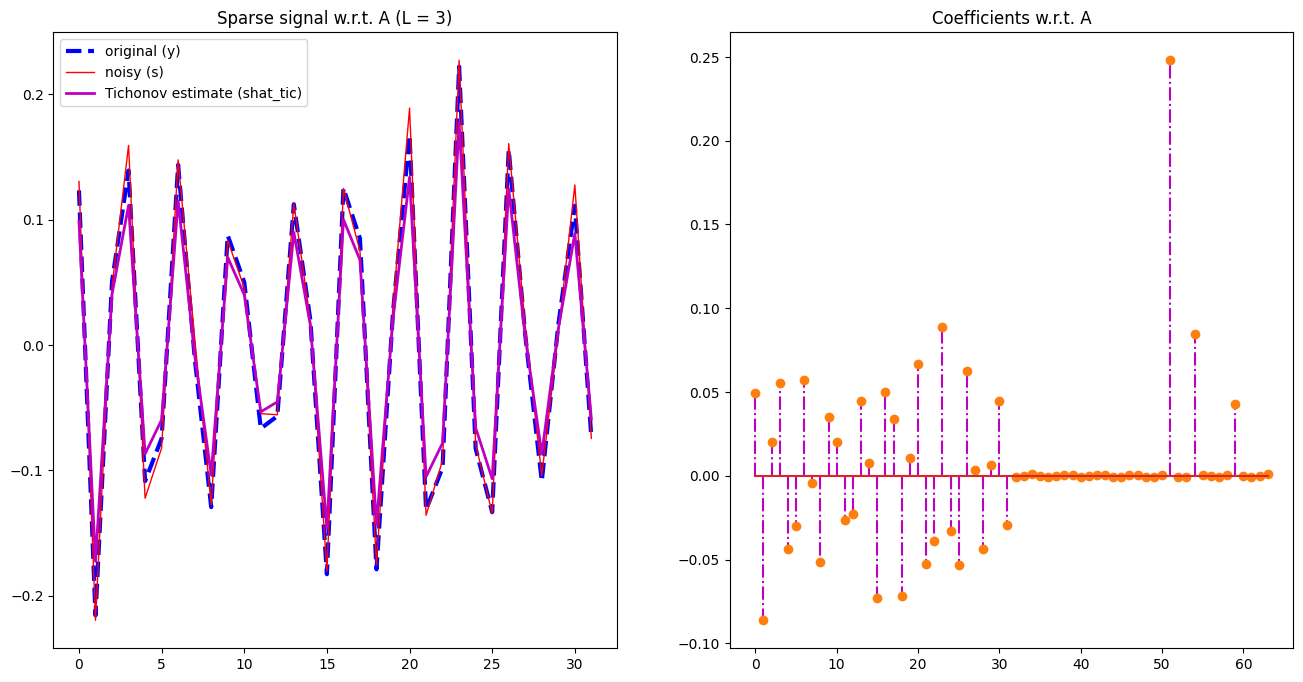

In [50]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(y, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'Tichonov estimate (shat_tic)'])

ax[1].stem(x_hat_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients w.r.t. A')